In [11]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Cargar el modelo entrenado (.h5)
modelo_ejercicio = load_model("modelo_ejercicios.h5")

# Clases (en orden del flow_from_directory)
clases = ['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust',
          'incline bench press', 'lat pulldown', 'lateral raises','leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift',
          'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']  # reemplaza con tus clases reales

def predecir_ejercicio(ruta_img):
    img = image.load_img(ruta_img, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = modelo_ejercicio.predict(img_array)
    clase = clases[np.argmax(pred)]
    return clase, np.max(pred)


In [81]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def analizar_postura(ruta_img):
    import cv2
    import numpy as np
    import tempfile
    import os
    import matplotlib.pyplot as plt
    import mediapipe as mp

    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils

    # Cargar imagen original
    img_bgr = cv2.imread(ruta_img)
    if img_bgr is None:
        return "Error: no se pudo cargar la imagen", None

    # Convertir a RGB y asegurar tipo
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = np.ascontiguousarray(img_rgb, dtype=np.uint8)

    # Guardar y recargar imagen para asegurar formato compatible
    tmpfile = tempfile.NamedTemporaryFile(suffix='.jpg', delete=False)
    tmpfile.close()  # cerrar el archivo para que OpenCV lo pueda usar
    tmp_path = tmpfile.name

    cv2.imwrite(tmp_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    img_bgr_fixed = cv2.imread(tmp_path)
    img_rgb = cv2.cvtColor(img_bgr_fixed, cv2.COLOR_BGR2RGB)

    os.unlink(tmp_path)  # ahora sí se puede eliminar

    # Procesar con MediaPipe
    with mp_pose.Pose(static_image_mode=True) as pose:
        try:
            results = pose.process(img_rgb)
        except TypeError as e:
            print("Error en MediaPipe al procesar la imagen:", e)
            return "Error al analizar postura", None

        if not results.pose_landmarks:
            return "Postura no detectada", None

        # Dibujar pose
        annotated = img_rgb.copy()
        mp_drawing.draw_landmarks(
            annotated, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        plt.imshow(annotated)
        plt.axis('off')
        plt.title('Postura detectada')
        plt.show()

        return "Postura detectada", results.pose_landmarks


In [83]:
def evaluar_postura(ejercicio, landmarks):
    if not landmarks:
        return "No se puede evaluar la postura"

    # Utilidades
    get = lambda lm: landmarks.landmark[lm]

    def altura(p): return get(p).y  # altura relativa
    def distancia_y(p1, p2): return abs(get(p1).y - get(p2).y)

    ejercicio = ejercicio.lower()

    # ---- SENTADILLA (SQUAT) ----
    if ejercicio == "squat":
        rodilla = altura(mp_pose.PoseLandmark.RIGHT_KNEE)
        cadera = altura(mp_pose.PoseLandmark.RIGHT_HIP)
        if rodilla > cadera:
            return "Squat correcta (bajada suficiente) ✔️"
        else:
            return "Squat incompleta (bajada insuficiente) ❌"

    # ---- PLANK ----
    elif ejercicio == "plank":
        hombro = altura(mp_pose.PoseLandmark.RIGHT_SHOULDER)
        cadera = altura(mp_pose.PoseLandmark.RIGHT_HIP)
        tobillo = altura(mp_pose.PoseLandmark.RIGHT_ANKLE)
        if abs(hombro - cadera) < 0.05 and abs(cadera - tobillo) < 0.05:
            return "Plank correcta (cuerpo alineado) ✔️"
        else:
            return "Plank incorrecta (alineación corporal deficiente) ❌"

    # ---- PUSH UP ----
    elif ejercicio == "push up":
        codo = altura(mp_pose.PoseLandmark.RIGHT_ELBOW)
        hombro = altura(mp_pose.PoseLandmark.RIGHT_SHOULDER)
        if codo > hombro:
            return "Push-up con buena bajada ✔️"
        else:
            return "Push-up incompleta (codos no bajan suficiente) ❌"

    # ---- DEADLIFT ----
    elif ejercicio == "deadlift":
        espalda_recta = abs(distancia_y(mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP)) < 0.15
        rodillas_flexionadas = altura(mp_pose.PoseLandmark.RIGHT_KNEE) > altura(mp_pose.PoseLandmark.RIGHT_ANKLE)
        if espalda_recta and rodillas_flexionadas:
            return "Deadlift con buena postura ✔️"
        else:
            return "Deadlift incorrecto (revisa espalda o rodillas) ❌"

    return f"Evaluación no disponible para: {ejercicio}"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Ejercicio detectado: squat (confianza: 1.00)


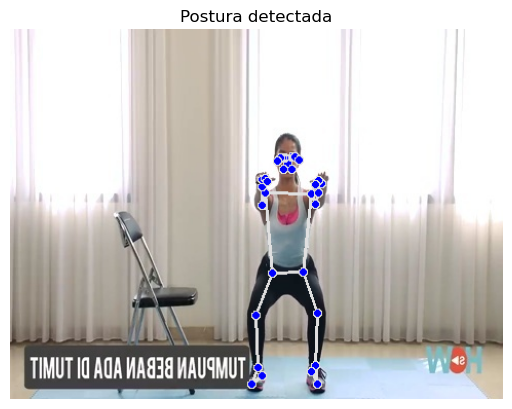

Postura detectada
Evaluación de postura: Squat correcta (bajada suficiente)


In [85]:
ruta_imagen = f"C:/Users/Anibal M/Desktop/hito 2 ML/dataset+/squat/squat_1900111_fliph.jpg"

# Paso 1: Clasificar el ejercicio
ejercicio, confianza = predecir_ejercicio(ruta_imagen)
print(f"Ejercicio detectado: {ejercicio} (confianza: {confianza:.2f})")

# Paso 2: Detectar postura
estado_postura, landmarks = analizar_postura(ruta_imagen)
print(estado_postura)

# Paso 3: Evaluar calidad de la ejecución
evaluacion = evaluar_postura(ejercicio, landmarks)
print(f"Evaluación de postura: {evaluacion}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


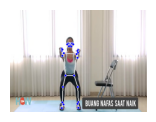

In [1]:
import tkinter as tk
from tkinter import filedialog, Label, Button, Frame
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# ---------------------- Modelo de Clasificación ----------------------
modelo_ejercicio = load_model("modelo_ejercicios.h5")
clases = ['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl',
          'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank',
          'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row',
          'tricep dips', 'tricep pushdown']

# ---------------------- MediaPipe ----------------------
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# ---------------------- Funciones ----------------------
def predecir_ejercicio(ruta_img):
    img = image.load_img(ruta_img, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = modelo_ejercicio.predict(img_array)
    clase = clases[np.argmax(pred)]
    return clase, np.max(pred)

def analizar_postura(ruta_img):
    img_bgr = cv2.imread(ruta_img)
    if img_bgr is None:
        return "Error: no se pudo cargar la imagen", None, None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = np.ascontiguousarray(img_rgb, dtype=np.uint8)

    with mp_pose.Pose(static_image_mode=True) as pose:
        results = pose.process(img_rgb)
        if not results.pose_landmarks:
            return "Postura no detectada", None, img_rgb

        # Dibuja la pose sobre la imagen
        annotated = img_rgb.copy()
        mp_drawing.draw_landmarks(annotated, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        return "Postura detectada", results.pose_landmarks, annotated

def evaluar_postura(ejercicio, landmarks):
    if not landmarks:
        return "No se puede evaluar la postura"

    get = lambda lm: landmarks.landmark[lm]
    altura = lambda p: get(p).y
    distancia_y = lambda p1, p2: abs(altura(p1) - altura(p2))

    ejercicio = ejercicio.lower()

    if ejercicio == "squat":
        return "✔️ Squat correcta" if altura(mp_pose.PoseLandmark.RIGHT_KNEE) > altura(mp_pose.PoseLandmark.RIGHT_HIP) else "❌ Squat incompleta"
    elif ejercicio == "plank":
        h, c, a = altura(mp_pose.PoseLandmark.RIGHT_SHOULDER), altura(mp_pose.PoseLandmark.RIGHT_HIP), altura(mp_pose.PoseLandmark.RIGHT_ANKLE)
        return "✔️ Plank alineado" if abs(h - c) < 0.05 and abs(c - a) < 0.05 else "❌ Plank desalineado"
    elif ejercicio == "push up":
        return "✔️ Buena bajada" if altura(mp_pose.PoseLandmark.RIGHT_ELBOW) > altura(mp_pose.PoseLandmark.RIGHT_SHOULDER) else "❌ Push-up incompleto"
    elif ejercicio == "deadlift":
        espalda = distancia_y(mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP) < 0.15
        rodilla = altura(mp_pose.PoseLandmark.RIGHT_KNEE) > altura(mp_pose.PoseLandmark.RIGHT_ANKLE)
        return "✔️ Deadlift correcto" if espalda and rodilla else "❌ Postura incorrecta"
    else:
        return f"ℹ️ Sin evaluación definida para {ejercicio}"

# ---------------------- GUI ----------------------
ventana = tk.Tk()
ventana.title("🧠 Evaluador de Ejercicios")
ventana.geometry("800x700")
ventana.configure(bg="#e3f2fd")

fuente = ("Helvetica", 12)
color_boton = "#1976d2"
color_texto = "#0d47a1"

# Widgets
titulo = Label(ventana, text="📸 Evaluación de Ejercicio y Postura", font=("Helvetica", 18, "bold"), bg="#e3f2fd", fg=color_texto)
titulo.pack(pady=15)

boton_cargar = Button(ventana, text="📂 Cargar Imagen", font=fuente, bg=color_boton, fg="white", command=lambda: cargar_imagen())
boton_cargar.pack(pady=10)

img_label = Label(ventana, bg="white")
img_label.pack(pady=10)

resultado_label = Label(ventana, text="", font=fuente, bg="white", wraplength=700, justify="center", relief="groove", bd=2, padx=10, pady=10)
resultado_label.pack(pady=10)

canvas_frame = Frame(ventana, bg="#e3f2fd")
canvas_frame.pack(pady=5)

def cargar_imagen():
    ruta = filedialog.askopenfilename(filetypes=[("Imágenes", "*.jpg *.png *.jpeg")])
    if ruta:
        # Clasificación
        ejercicio, confianza = predecir_ejercicio(ruta)

        # Postura
        estado, landmarks, img_annotated = analizar_postura(ruta)
        evaluacion = evaluar_postura(ejercicio, landmarks)

        # Mostrar imagen
        img_pil = Image.open(ruta).resize((300, 300))
        img_tk = ImageTk.PhotoImage(img_pil)
        img_label.config(image=img_tk)
        img_label.image = img_tk

        # Texto
        resultado_label.config(text=f"🏋️‍♂️ Ejercicio detectado: {ejercicio}\n📊 Confianza: {confianza:.2f}\n📍 {estado}\n📝 Evaluación: {evaluacion}")

        # Mostrar imagen con postura en matplotlib
        for widget in canvas_frame.winfo_children():
            widget.destroy()

        if img_annotated is not None:
            fig, ax = plt.subplots(figsize=(4, 4))
            ax.imshow(img_annotated)
            ax.axis("off")
            canvas = FigureCanvasTkAgg(fig, master=canvas_frame)
            canvas.draw()
            canvas.get_tk_widget().pack()

ventana.mainloop()
